<img src=https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/6ra7ymjkfi64845 width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

Daniel Vidal Soroa  
Juan Diego Peña 

## Clasificación de mangos en tres clases según su presencia para la exportación, comercio local o procesamiento industrial

#### Importación de las librerías:

In [32]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential, Model
from keras.applications import vgg16, mobilenet, resnet, xception
from keras.layers import Flatten, Dense
from tensorflow import keras
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from random import seed
from random import randint
from keras import layers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical")
])

# Función para mostrar lista de imágenes en escala de grises
def show_row_of_gray_images(fig_width, *images):
    plt.figure(figsize=(fig_width, fig_width))
    images_count = len(images)
    index = 1  
    for image in images:
        plt.subplot(1, images_count, index)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        index+=1

def save_results(key, eval_time, acc, encoding):
    test_data = {
        'input_dim': str(IMG_SIZE) + 'x' + str(IMG_SIZE),
        'encoder_dim': str(encoded_dim),
        'epochs': epochs,
        'batch_size': batch_size,
        'dim_reduction': encoding,
        'model': key,
        'acc': acc,
        'eval time': eval_time
        }

    now = datetime.now() # current date and time       
    time_ = {now.strftime("%d/%m/%Y %H:%M:%S")}
    df = pd.DataFrame(test_data, index = time_)
    excel_name = "./informe/tables/DimensionReduction.xlsx"
    append_data_to_excel(excel_name, df)

# Función para añadir datos a una tebla de excel
def append_data_to_excel(excel_name, df):
    with pd.ExcelWriter(excel_name,
        mode="a",
        engine="openpyxl",
        if_sheet_exists="overlay") as writer:
        start_row = 0
        header = True
        if os.path.exists(excel_name):
            df_source = pd.read_excel(excel_name, engine="openpyxl").iloc[:,1:]
        if df_source is not None:
            n, m = df_source.shape
            header = False if n > 0 else True
            start_row = n + 1 if n > 0 else n
        
        df.to_excel(writer, sheet_name="Sheet1",startcol=0, startrow = start_row, header=header)

# Función para graficar progreso durante el entrenamiento de la red 
def plot_history(history):
    plt.figure(figsize=(12,5))
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label = 'Validación')
    plt.xlabel('Iteración (epoch)')
    plt.ylabel('Exactitud (accuracy)')
    plt.ylim([0, 1])
    plt.grid()
    plt.title('Modelo '+str(i+1))
    plt.legend(loc='lower right')

# Distintas arquitectura para salida de la red neuronal
def cnn1(_input_shape, classes):
    model = Sequential()
    model.add(Flatten(input_shape=_input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(classes, activation='softmax'))   
    return model

# Devuelve un modelo preentrenado según el nombre solicitado
def get_base_model(name,input_size):
    if name == 'vgg':
        return vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(input_size,input_size,3))
    elif name == 'mobilnet':
        return mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=(input_size,input_size,3))
    elif name == 'xception':
        return xception.Xception(include_top=False, weights='imagenet', input_shape=(input_size,input_size,3))
    else: return resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(input_size,input_size,3))


#### Lectura y aumento de datos, definición de datos de entrenamiento, validación y prueba:

850
759
461


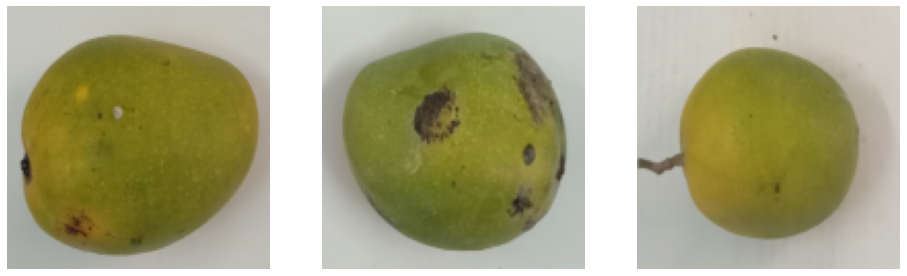

In [2]:
# seed random number generator
seed(1)

# Dimensión de entrada de las imágenes 
IMG_SIZE = 128
h = IMG_SIZE
w = IMG_SIZE

# Leer los nombres de las imágenes para importarlas
input_class1_path = "./Dataset/Grading_dataset/Class_I"
class1_names = os.listdir(input_class1_path)
input_class2_path = "./Dataset/Grading_dataset/Class_II"
class2_names = os.listdir(input_class2_path)
input_classex_path = "./Dataset/Grading_dataset/Extra_Class"
class3_names = os.listdir(input_classex_path)

# Número de elementos en cada clase
n = len(class1_names)

# Definir listas para cargar imágenes
class1 = np.ones([n, h, w, 3])
class2 = np.ones([n, h, w, 3])
class3 = np.ones([n, h, w, 3])

for i in range(0, n, 1):
    # Para cada clase, se lee una imágen, se importa
    img = resize(imread("./Dataset/Grading_dataset/Class_I/" + class1_names[i]), (h, w))
    class1[i] = img  
    img = resize(imread("./Dataset/Grading_dataset/Class_II/" + class2_names[i]), (h, w))
    class2[i] = img 
    img = resize(imread("./Dataset/Grading_dataset/Extra_Class/" + class3_names[i]), (h, w))
    class3[i] = img 

# Aumentamos por un factor f el número de datos de cada clase
f = 5
class1_augmeted = np.zeros([n * f, h, w, 3])
class2_augmeted = np.zeros([n * f, h, w, 3])
class3_augmeted = np.zeros([n * f, h, w, 3])
t1 = np.zeros(n * f)
t2 = np.zeros(n * f)
t3 = np.zeros(n * f)

for i in range(n * f):
    rn = randint(0, n-1)
    img = class1[rn]
    new_img = data_augmentation(img)
    class1_augmeted [i] = new_img
    t1[i] = 1
    
    rn = randint(0, n-1)
    img = class2[rn]
    new_img = data_augmentation(img)
    class2_augmeted [i] = new_img
    t2[i] = 2
    
    rn = randint(0, n-1)
    img = class3[rn]
    new_img = data_augmentation(img)
    class3_augmeted [i] = new_img
    t3[i] = 0

# Se imprimen tres imágenes aleatorias de los datos aumentados para comprobar que funciona    
limit1 = len(class1_augmeted)
rn = randint(0, limit1 - 1)
img_1 = class1_augmeted[rn]
print (rn)

limit2 = len(class2_augmeted)
rn = randint(0, limit2 - 1)
img_2 = class2_augmeted[rn]
print (rn)

limit3 = len(class3_augmeted)
rn = randint(0, limit3 - 1)
img_3 = class3_augmeted[rn]  
print (rn)

show_row_of_gray_images(16, img_1, img_2, img_3)

# Se define el conjunto de datos de entrenamiento
X = np.concatenate((class3_augmeted, class1_augmeted, class2_augmeted), axis = 0)

# Se definen las etiquetas de las clases
t = np.concatenate((t3, t1, t2), axis = 0)

X_train_val, X_test, t_train_val, t_test = train_test_split(X, t, test_size=0.3,shuffle=True)
X_train, X_val, t_train, t_val = train_test_split(X_train_val, t_train_val, test_size=0.3, shuffle=True)
train_target = tf.keras.utils.to_categorical(t_train)
val_target = tf.keras.utils.to_categorical(t_val)
test_target = tf.keras.utils.to_categorical(t_test)


Definición y entrenamiento de red autoencóder

In [53]:
encoded_dim = 32
IMG_SIZE = 128

encoder = Sequential([
    layers.Conv2D(input_shape=(IMG_SIZE,IMG_SIZE,3), filters= 64, kernel_size= (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D( (2, 2), padding='same'),
    layers.Conv2D(3, (3, 3), activation='linear', padding='same')
])

decoder = Sequential ([
    layers.UpSampling2D((2, 2), input_shape=(encoded_dim,encoded_dim,3)),
    layers.Conv2D(filters=32, kernel_size= (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D( (2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(3, (3, 3), activation='linear', padding='same')
])

#epochs = 10
#batch_size = 30
#autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))
#autoencoder_dr.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ["mean_squared_error"])
#history = autoencoder_dr.fit(X_train, X_train, validation_data = (X_val, x_valid_scaled), epochs=epochs, batch_size=batch_size, verbose=1)

autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))
autoencoder_dr.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ["mean_squared_error"])
batch_size = 40
epochs = 10
history = autoencoder_dr.fit(X_train, X_train, validation_data=(X_val, X_val), epochs = epochs, batch_size=batch_size, verbose=1)

Epoch 1/10
46/46 [==============================] - 235s 5s/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 2/10
46/46 [==============================] - 251s 5s/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 3/10
46/46 [==============================] - 266s 6s/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/10
46/46 [==============================] - 256s 6s/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/10
46/46 [==============================] - 252s 5s/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.8853e-04 - val_mean_squared_error: 9.8853e-04
Epoch 6/10
46/46 [==============================] - 271s 6s/step - loss: 9.3617e-04 - mean_squared_error: 9.3617e-04 - val_loss: 9.3593e-04 - val_mean_squared_error: 9.3593e-04
Epoch 7/10

Se muestran los resultados de la red autoencoder y el resultado obtenido luego de la etapa de codificación

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


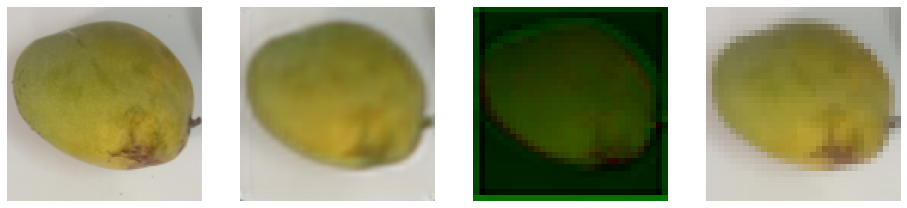

In [55]:
img = np.expand_dims(X_test[0],0)
img_y = autoencoder_dr.predict(img)
img_encoder = encoder.predict(img)
show_row_of_gray_images(16, img[0], img_y[0], img_encoder[0], resize( img[0],(32,32,3)))

Se grafica la evolución del entrenamiento para detectar sobre ajustes

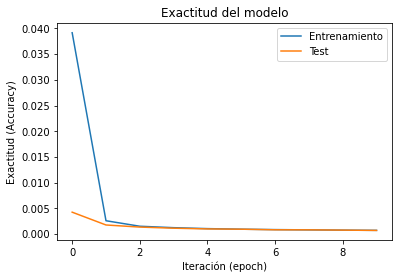

In [56]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud (Accuracy)')
plt.xlabel('Iteración (epoch)')
plt.legend(['Entrenamiento', 'Test'], loc='upper right')
plt.show()

Evaluación de clasificadores

In [43]:

CV = 10
scores = {}
scoring = ['accuracy']
classifiers = { 'LDA' : LinearDiscriminantAnalysis(),
                'RForest' : RandomForestClassifier(n_estimators=20, criterion='gini')}

for i, key in enumerate(classifiers):
    print("Evaluando modelo:", key)
    tic = time.perf_counter()
    scores[key] = cross_validate(classifiers[key], X_train_reshaped, t_train, cv=CV, scoring=scoring)
    toc = time.perf_counter()
    eval_time = round((toc-tic), 2)
    acc = round(np.mean(scores[key]['test_accuracy']),2)
    save_results(key, eval_time, acc, encoding)
    print('Media del modelo', key, 'es :', acc)


Evaluando modelo: LDA
Media del modelo LDA es : 0.33
Evaluando modelo: RForest
Media del modelo RForest es : 0.71


#### Se importa la red VGG16 para utilizar su arquitectura y conocimento para resolver nuestro problema, además se definen las capas finales de nuestro modelo 

In [21]:
# Se importa la red preentrenada
model_name = "vgg"
pretrained_model = get_base_model(model_name,encoded_dim)

# Se definen las capas finales del modelo
classes = 3
input_shape = pretrained_model.output_shape[1:4]
modelCNN = cnn1(input_shape, classes)
opt = keras.optimizers.Adam(learning_rate=0.0005)
modelCNN.compile(optimizer=opt, metrics='accuracy', loss='categorical_crossentropy')
modelCNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 33,027
Trainable params: 33,027
Non-trainable params: 0
_________________________________________________________________


#### Finalmente se realiza la clasificación utilizando las capas finales de la red

In [22]:
encoding = True
batch_size = 50
epochs = 250

if encoding:
    X_train_resized = X_encoded
else:
    X_train_resized = resize(X_train,(len(X_train),encoded_dim,encoded_dim,3))
    X_test_resized = resize(X_test, (len(X_test), encoded_dim, encoded_dim, 3))
    X_val_resized = resize(X_val,(len(X_val),encoded_dim,encoded_dim,3))

# Se entrena la red definida para la clasificación final
print("Extrayendo características")
features_train = pretrained_model.predict(X_train_resized)
features_val = pretrained_model.predict(X_val_resized)
history = modelCNN.fit(features_train, train_target, epochs=epochs, batch_size=batch_size, validation_data=(features_val, val_target), verbose=True)


Epoch 1/250
30/30 [==============================] - 3s 27ms/step - loss: 1.0928 - accuracy: 0.4231 - val_loss: 1.0625 - val_accuracy: 0.3762
Epoch 2/250
30/30 [==============================] - 0s 9ms/step - loss: 1.0197 - accuracy: 0.5068 - val_loss: 0.9872 - val_accuracy: 0.5714
Epoch 3/250
30/30 [==============================] - 0s 7ms/step - loss: 0.9662 - accuracy: 0.5653 - val_loss: 0.9373 - val_accuracy: 0.5984
Epoch 4/250
30/30 [==============================] - 0s 7ms/step - loss: 0.9258 - accuracy: 0.5816 - val_loss: 0.8954 - val_accuracy: 0.6127
Epoch 5/250
30/30 [==============================] - 0s 7ms/step - loss: 0.8882 - accuracy: 0.5973 - val_loss: 0.8744 - val_accuracy: 0.5857
Epoch 6/250
30/30 [==============================] - 0s 7ms/step - loss: 0.8654 - accuracy: 0.6034 - val_loss: 0.8258 - val_accuracy: 0.6619
Epoch 7/250
30/30 [==============================] - 0s 8ms/step - loss: 0.8395 - accuracy: 0.6177 - val_loss: 0.8087 - val_accuracy: 0.6556
Epoch 8/250


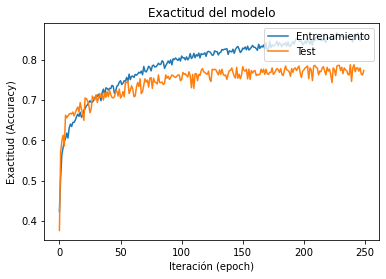

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud (Accuracy)')
plt.xlabel('Iteración (epoch)')
plt.legend(['Entrenamiento', 'Test'], loc='upper right')
plt.show()

Media del modelo cnn es : 0.62


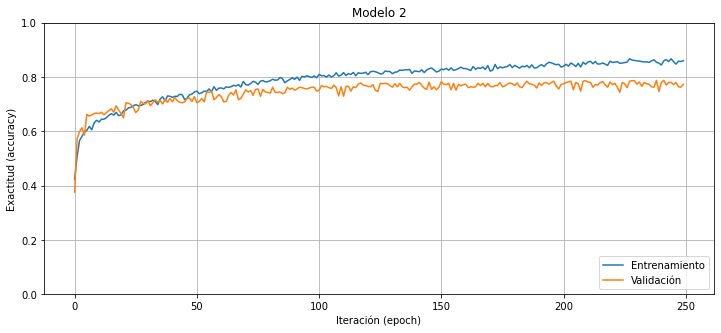

In [24]:
# Se evalua el modelo
key = "cnn"
tic = time.perf_counter()
features_test = pretrained_model.predict(X_test_resized)
test_acc = modelCNN.evaluate(features_test,  test_target, verbose=0)
toc = time.perf_counter()
eval_time = round((toc-tic), 2)
plot_history(history)
acc = round(np.mean(test_acc),2)
save_results(key, eval_time, acc, encoding)
print('Media del modelo', key, 'es :', acc)